# Part 7 - Watershed Algorithm
- In geography, a watershed is a land area that channels rainfall and snowmelt to creeks, streams and rivers and eventually to outflow points such as reservoirs, bays and the ocean.
- these watersheds can then be segmented as topographical maps with boundaries.

![land Watershed](https://5.imimg.com/data5/QB/ED/SM/SELLER-1206617/watershed-treatment-services-500x500.png)

- Metaphorically, the watershed algorithm transformation treats the image it operates upon like a topographic map, with the brighness of each point representing its height and finds the lines that run along the tops of ridges.
- Any gray scale image can be viewed as a topographic surface where **high intensity** denotes peaks and hills while **low intensity** denotes valleys.
- The algorithm can then fill every isolated valleys (local minima) with different colored water (labels).
- As the "water" rises, depending on the peaks (gradients) nearby, "water" from different valleys (different segments of the image), with different colors could start to merge.
- To avoid this merging, the algorithm creates barriers (segment edge boundaries) in locations where "water" merges.
- This algorithm is especially useful for segmenting images into background and foreground in situations that are difficult for other algorithms.
- A common example is the use of coins next to each other on a table.
- Attempting to segment these coins can be difficult.
- The watershed algorithm can be very effective for these sort of problems.
- Later on we will also learn how to provide our own custom "seeds" that allow us to manually start where the valleys of the watersheds go.

![Coins on a table](image-1.jpg)

In [2]:
import os
import sys

current_dir = os.path.abspath("")
parent_dir  = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from utilities import show_img

import numpy as np
import cv2

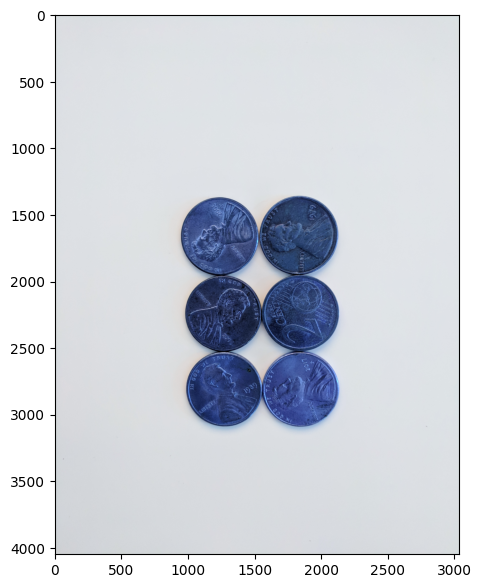

In [2]:
sep_coins = cv2.imread("../DATA/pennies.jpg")

show_img(sep_coins, figsize=(7, 7))

In [3]:
# steps:
# median blur
# gray scale conversion
# binary thresholding
# find the contours

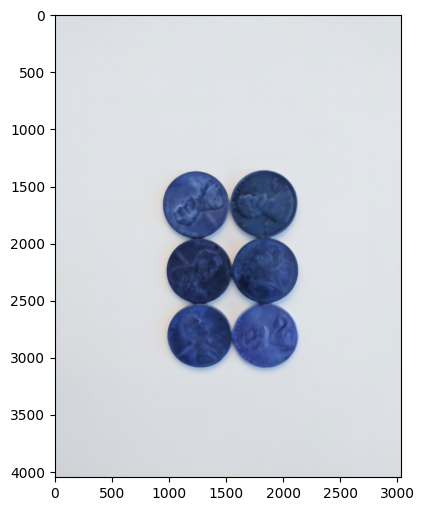

In [4]:
sep_blur = cv2.medianBlur(sep_coins, ksize=25)

show_img(sep_blur, figsize=(6, 6))

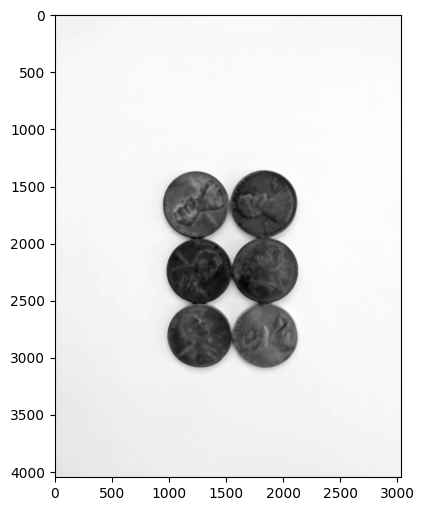

In [5]:
gray_sep_coins = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)

show_img(gray_sep_coins, figsize=(6, 6))

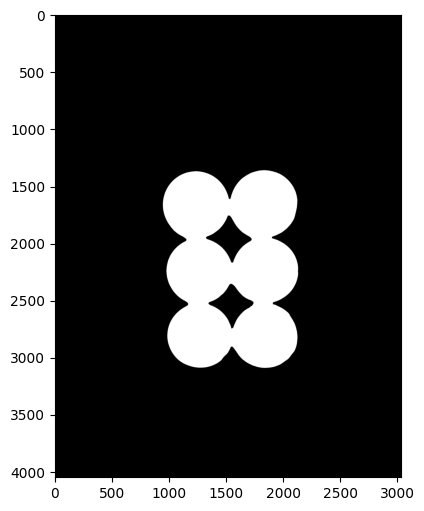

In [6]:
ret, sep_thresh = cv2.threshold(gray_sep_coins, thresh=160, maxval=255, type=cv2.THRESH_BINARY_INV)

show_img(sep_thresh, figsize=(6, 6))

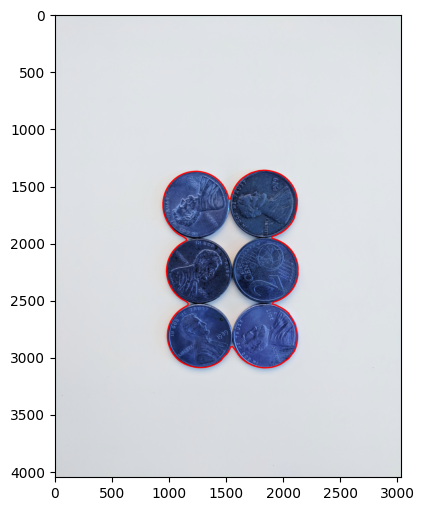

In [7]:
contours, hierarchy = cv2.findContours(sep_thresh.copy(), mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours=contours, contourIdx=i, color=(255, 0, 0), thickness=10)
        
show_img(sep_coins, figsize=(6, 6))

## Watershed Algorithm (Prepare the Image by Hand)

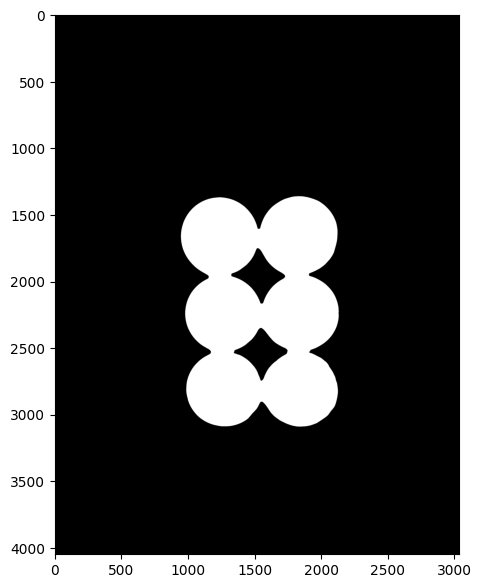

In [8]:
img = cv2.imread("../DATA/pennies.jpg")

# blur the image (for high resolution image, high kernel size performs well)
img = cv2.medianBlur(img, ksize=35)

# convert to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# thresholding
# ret, thresh = cv2.threshold(gray, thresh=127, maxval=255, type=cv2.THRESH_BINARY_INV)

# after doing all there, some features are capured. This can remove
# by Otsu's method (https://en.wikipedia.org/wiki/Otsu%27s_method)
# show_img(thresh, figsize=(7, 7))
# You can apply this method on the thresholding technique within
ret, thresh = cv2.threshold(gray, thresh=0, maxval=255, type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# helpful for more complex images --> noise removal
kernel = np.ones((3, 3), dtype=np.uint8)
opening = cv2.morphologyEx(thresh, op=cv2.MORPH_OPEN, kernel=kernel, iterations=2)

show_img(opening, figsize=(7, 7))

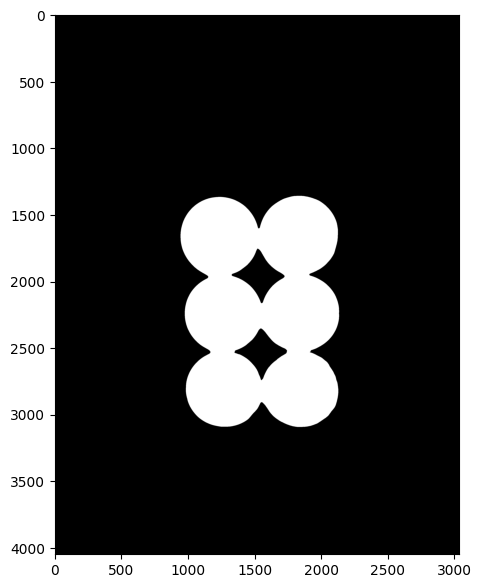

In [9]:
sure_bg = cv2.dilate(opening, kernel=kernel, iterations=3)

show_img(sure_bg, figsize=(7, 7))

[Distance Transform](https://en.wikipedia.org/wiki/Distance_transform)

![Distance Transform Example](https://miro.medium.com/max/480/1*b7gJ0Z-_RT3At_u96t1DPQ.gif)

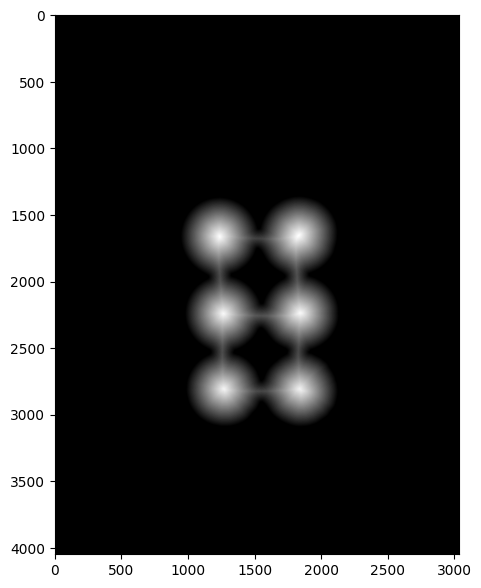

In [10]:
dist_transform = cv2.distanceTransform(opening, distanceType=cv2.DIST_L2, maskSize=5)

show_img(dist_transform, figsize=(7, 7))

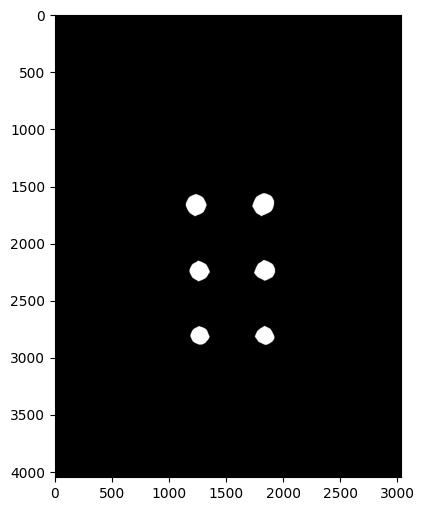

In [11]:
# from distance transformation, we can get the 6 points of the 6 pennies.
# Now if we apply another thresholding, we can find those points.
ret, sure_fg = cv2.threshold(dist_transform, thresh=0.7*dist_transform.max(), maxval=255, type=cv2.THRESH_BINARY)

show_img(sure_fg, figsize=(6, 6))

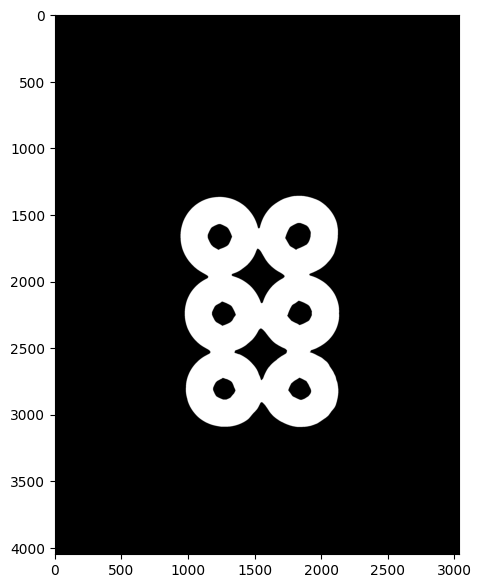

In [12]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# these white areas we are not sure that are those belong to foreground
# or background
show_img(unknown, figsize=(7, 7))

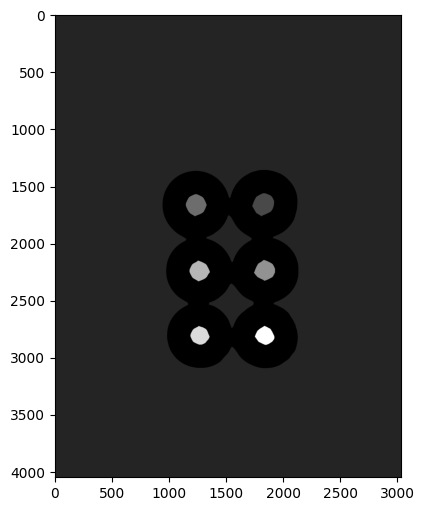

In [13]:
# create the label markers
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1

markers[unknown==255] = 0

show_img(markers, figsize=(6, 6))

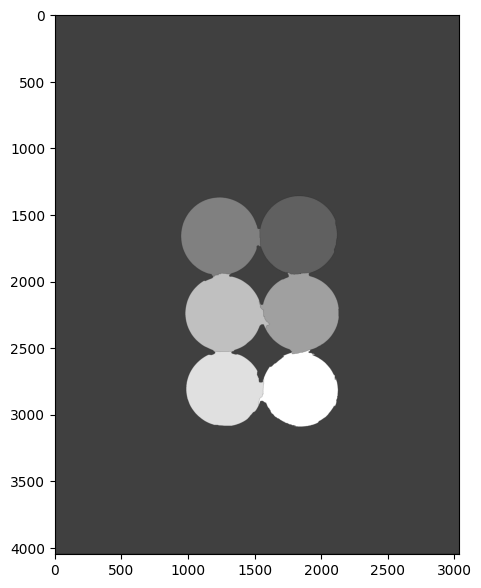

In [14]:
markers = cv2.watershed(img, markers=markers)

show_img(markers, figsize=(7, 7))

In [15]:
contours, hierarchy = cv2.findContours(markers.copy(), mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours=contours, contourIdx=i, color=(255, 0, 0), thickness=10)

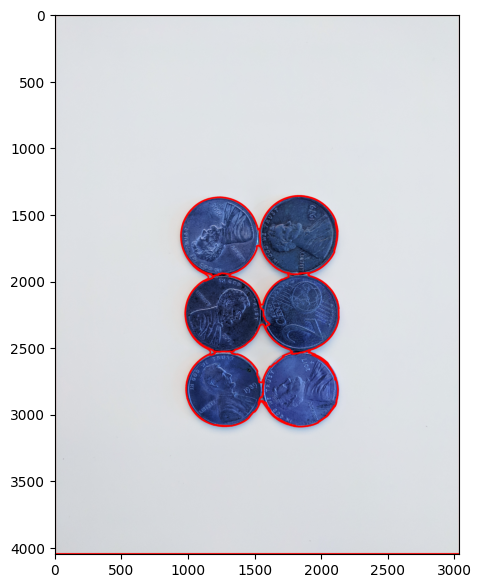

In [16]:
show_img(sep_coins, figsize=(7, 7))

## Watershed Algorithm (In convenient way)

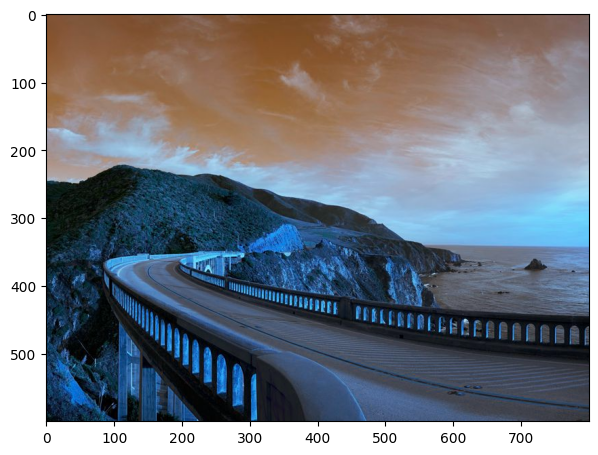

In [17]:
road = cv2.imread("../DATA/road_image.jpg")
road_copy = np.copy(road)

show_img(road, figsize=(7, 7))

In [18]:
marker_image = np.zeros(road.shape[:2], dtype=np.int32)
segments = np.zeros(road.shape, dtype=np.uint8)

# color maping
from matplotlib import cm

cm.tab10(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

In [19]:
def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3]) * 255)

colors = []
for i in range(10):
    colors.append(create_rgb(i))
    
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [20]:
###

# global variables
n_markers = 10  # color choise - 0 to 9
current_marker = 1
# markers updated by Watershed Algorithm
marks_updated = False

# callback function
def mouse_callback(event, x, y, flags, param):
    global marks_updated
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # markers passed to the watershed algorithm
        cv2.circle(marker_image, center=(x, y), radius=10, color=(current_marker), thickness=-1)
        
        # user sees on the road image
        cv2.circle(road_copy, center=(x, y), radius=10, color=colors[current_marker], thickness=-1)
        
        marks_updated = True

# while true
cv2.namedWindow("Road Image", cv2.WINDOW_NORMAL)
cv2.namedWindow("Watershed Segments", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Road Image", mouse_callback)

while True:
    
    cv2.imshow("Watershed Segments", segments)
    cv2.imshow("Road Image", road_copy)
    
    # close all windows
    k = cv2.waitKey(1)
    
    if k == 27:  # esc key
        break
        
    # clearing all the colors while pressing C key
    elif k == ord("c"):
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[:2], dtype=np.int32)
        segments = np.zeros(road.shape, dtype=np.uint8)
    
    # update color choice
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k))
    
    
    # update the markings
    if marks_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road, markers=marker_image_copy)
        
        segments = np.zeros(road.shape, dtype=np.uint8)
        
        for color_ind in range(n_markers):
            # coloring the segments, numpy call
            segments[marker_image_copy == (color_ind)] = colors[color_ind]
        
        marks_updated = False
    
    
cv2.destroyAllWindows()